In [1]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
import time
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from ORAN_dataset import *

File config

In [2]:
# Notebook config
labels = {0: 'eMBB', 1: 'mMTC', 2: 'URLLc', 3: 'CTRL'}
font = {'size'   : 22}
matplotlib.rc('font', **font)
np.random.seed(42)

ds_pkl_path = "../logs/"
# Data file config
# Trial 7
ds_file = "SingleUE/dataset__emuc__Trial7__slice16_singleUE_raw_debug_CNTRL_trial7_raw__globalnorm.pkl"
norm_param_path = "../logs/global__cols_maxmin__debug_CNTRL_trial7_raw_slice16.pkl"
# Trial 1-6
#ds_file = "SingleUE/prev_experiments/dataset__emuc__Trial1_Trial2_Trial3_Trial4_Trial5_Trial6__slice16__globalnorm.pkl"
#norm_param_path = "../logs/SingleUE/prev_experiments/global__cols_maxmin__prevexp_globalnorm_slice16.pkl"
ds_path = "../"

T = int(norm_param_path.split('slice')[-1].split('.')[0])

In [3]:
args = {
    "ds_file": [ds_file],
    "isNorm": True,
    "ds_path": ds_pkl_path,
    "norm_param_path": norm_param_path,
    "relabel_train": False
}
    
print("--- Loading Train dataset without relabeling...")
# Not relabeled
ds_train_nr = ORANTracesDataset(args["ds_file"], key='train', normalize=args["isNorm"], sanitize=False, path=args["ds_path"], norm_par_path=args["norm_param_path"], relabel_CTRL=args["relabel_train"])
ds_info = ds_train_nr.info()
print(ds_info)
print("--- Loading Train dataset relabeling...")
# Relabeled
args['relabel_train'] = True
ds_train_rel = ORANTracesDataset(args["ds_file"], key='train', normalize=args["isNorm"], sanitize=False, path=args["ds_path"], norm_par_path=args["norm_param_path"], relabel_CTRL=args["relabel_train"])
ds_info = ds_train_rel.info()
print(ds_info)

--- Loading Train dataset without relabeling...
{'numfeats': 17, 'slice_len': 16, 'numsamps': 79715, 'nclasses': 4, 'samples_per_class': array([29073, 27829, 22376,   437])}
--- Loading Train dataset relabeling...
Initial # samps. per label (before relabeling)
	 Labels: [0 1 2 3] Count: [29073 27829 22376   437]
	Labels that contain norm < threshold [0 1 2 3] 
	Num of samples per label with norm < threshold: [10454 14624  8010   391]
Tot. samples relabeled (for every class): 33088
{'numfeats': 17, 'slice_len': 16, 'numsamps': 79715, 'nclasses': 4, 'samples_per_class': array([18619, 13205, 14366, 33525])}


In [4]:
# Check if X of datasets are the same 
df_rn = []
df_r = []
for i in range(len(ds_train_nr)):
    df_rn.append(ds_train_nr[i][0].flatten().numpy())
    df_r.append(ds_train_rel[i][0].flatten().numpy())
    
result = True
# Check if the lists are identical
for k in range(len(df_r)):
    if not (df_rn[k] == df_r[k]).all():
        result = False
        
# Print the result
print("The lists are identical:", result)

The lists are identical: True


In [5]:
N = 10000000
samples_per_class = [0, 0, 0, 0]
df_subset = []
df_classes_nr = []
df_classes_r = []

for i in range(len(ds_train_rel)):
    # If we have enough samples of that class do not add
    label_rel = ds_train_rel[i][1].item()
    label_nr = ds_train_nr[i][1].item()
    if samples_per_class[label_rel] < N:
        df_subset.append(ds_train_rel[i][0].flatten().numpy())
        df_classes_r.append(label_rel)
        samples_per_class[ds_train_rel[i][1].item()] += 1
        df_classes_nr.append(label_nr)
        

df_subset = np.array(df_subset)

In [6]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, learning_rate='auto',init='random', perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(df_subset)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 79715 samples in 0.011s...
[t-SNE] Computed neighbors for 79715 samples in 129.561s...
[t-SNE] Computed conditional probabilities for sample 1000 / 79715
[t-SNE] Computed conditional probabilities for sample 2000 / 79715
[t-SNE] Computed conditional probabilities for sample 3000 / 79715
[t-SNE] Computed conditional probabilities for sample 4000 / 79715
[t-SNE] Computed conditional probabilities for sample 5000 / 79715
[t-SNE] Computed conditional probabilities for sample 6000 / 79715
[t-SNE] Computed conditional probabilities for sample 7000 / 79715
[t-SNE] Computed conditional probabilities for sample 8000 / 79715
[t-SNE] Computed conditional probabilities for sample 9000 / 79715
[t-SNE] Computed conditional probabilities for sample 10000 / 79715
[t-SNE] Computed conditional probabilities for sample 11000 / 79715
[t-SNE] Computed conditional probabilities for sample 12000 / 79715
[t-SNE] Computed conditional probabilities for 

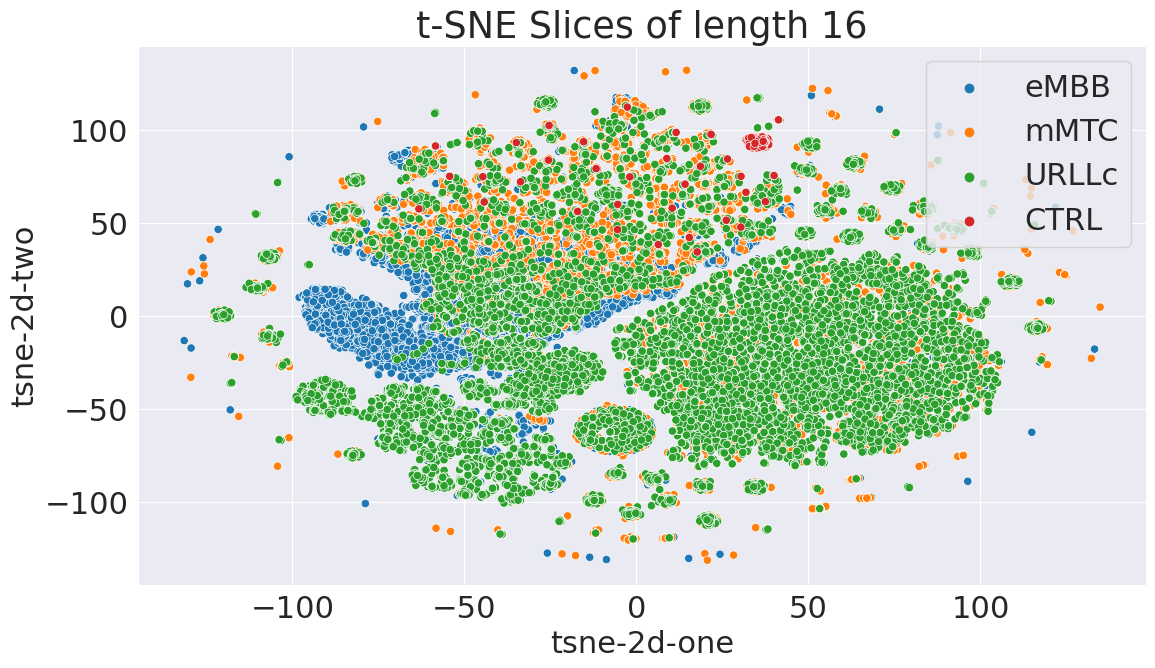

In [7]:
fig = plt.figure(figsize=(13,7))
df_plot = pd.DataFrame.from_dict({'tsne-2d-one': tsne_results[:,0], 'tsne-2d-two': tsne_results[:,1]})
df_plot['class'] = df_classes_nr
df_plot['Class'] = df_plot['class'].apply(lambda x: labels[x])
df_plot.sort_values(by=['class'], inplace=True)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='Class',
    hue_order = ['eMBB', 'mMTC', 'URLLc', 'CTRL'],
    palette=sns.color_palette("tab10", 4),
    data=df_plot,
    legend="full",
    alpha=1
).set(title=f't-SNE Slices of length {T}')
plt.legend(loc='upper right')
plt.savefig(f"../logs/SingleUE/prev_experiments/Before relabeling Slice {T}.png", transparent=True)

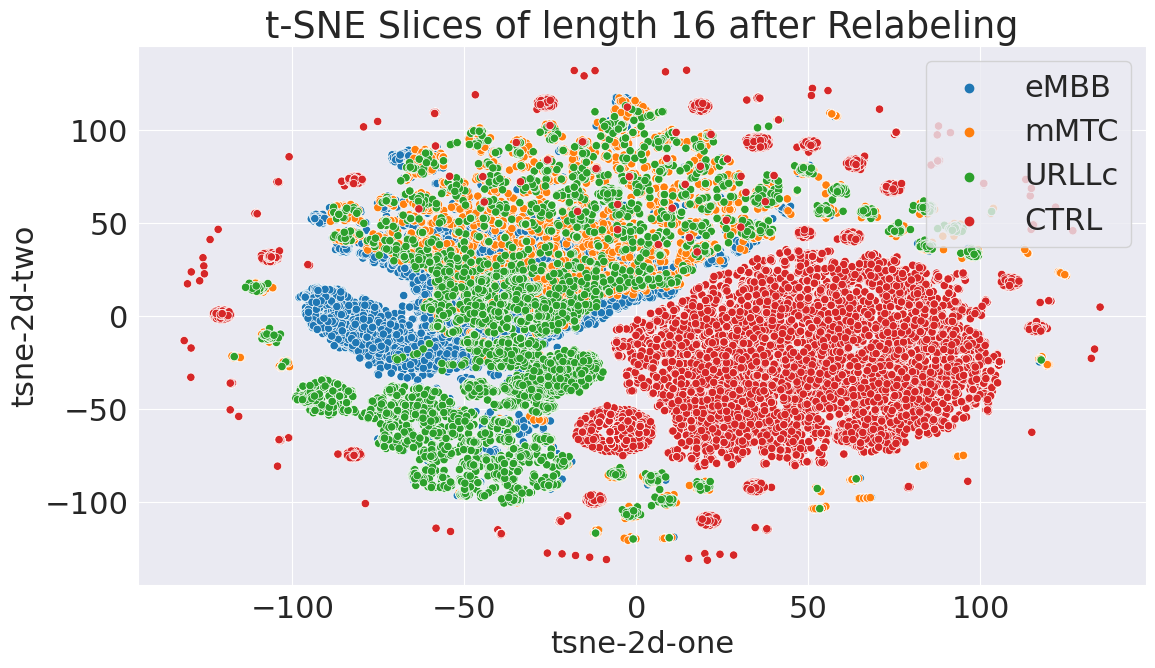

In [8]:
plt.figure(figsize=(13,7))
df_plot = pd.DataFrame.from_dict({'tsne-2d-one': tsne_results[:,0], 'tsne-2d-two': tsne_results[:,1]})
df_plot['class'] = df_classes_r
df_plot['Class'] = df_plot['class'].apply(lambda x: labels[x])
df_plot.sort_values(by=['class'], inplace=True)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='Class',
    hue_order = ['eMBB', 'mMTC', 'URLLc', 'CTRL'],
    palette=sns.color_palette("tab10", 4),
    data=df_plot,
    legend="full",
    alpha=1
).set(title=f't-SNE Slices of length {T} after Relabeling')
plt.legend(loc='upper right')
plt.savefig(f"../logs/SingleUE/prev_experiments/Relabeled Slice {T}.png", transparent=True)

In [9]:
df_subset.shape

(79715, 272)

In [10]:
df_subset_og_shape = df_subset.reshape((df_subset.shape[0],16,17))

# Visualization analysis
In this section we aim to visualize the features grouped in clusters by t-SNE algorithm. First, we show a (random) example of non-CTRL traffic.

Non-CTRL sample # 54030


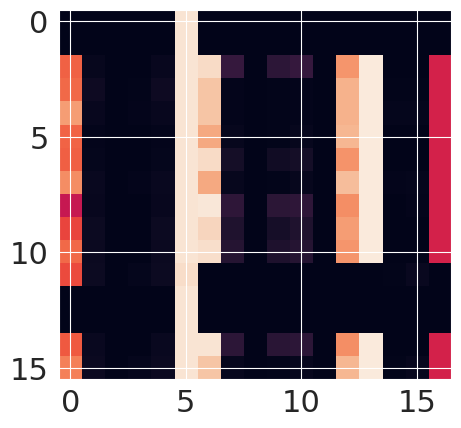

In [11]:
ix = np.random.choice(np.where(np.array(df_classes_r) != 3)[0])
print("Non-CTRL sample #", ix)
matplotlib.pyplot.imshow(df_subset_og_shape[ix])

Let's now take a closer look to the CTRL samples. Specifically, we want to visualize the samples in the large cluster in the bottom-right corner of t-SNE visualization output, in order to understand how features belonging to this cluster look like. The reason to do this is because we observe not only a sample similarity identified by t-SNE, but also it happens to contain a large number of samples relabeled as CTRL using the heuristic explained in the MEGATRON paper. 

We first obtain all the indexes of CTRL samples *after* relabeling procedure.

In [12]:
ctrl_after_relabel_ixs = np.where(np.array(df_classes_r) == 3)[0]

Then we randomly sample 30 of such CTRL samples and we plot only the ones that are contained in a rectangular area within the large cluster, specifically the ones that have coordinate $50 < x < 0$ and $0 > y > -50$ in the t-SNE visualization. Note that such boundaries should be chosen based on the visualization output, so they would need to be updated for a different run of t-SNE algorithm. 

From the plots below, we can see that samples in the rectangular area of interest within the cluster are indeed very similar to each other and they present almost identical features. Moreover, such features forms patterns that closely resembles the mean CTRL template used to relabel idle portions of traffic in other classes, demonstrating the validity of proposed relabeling approach. 

ORIGINAL LABEL: 2 COORDINATES [ 24.950165 -32.667202 ]


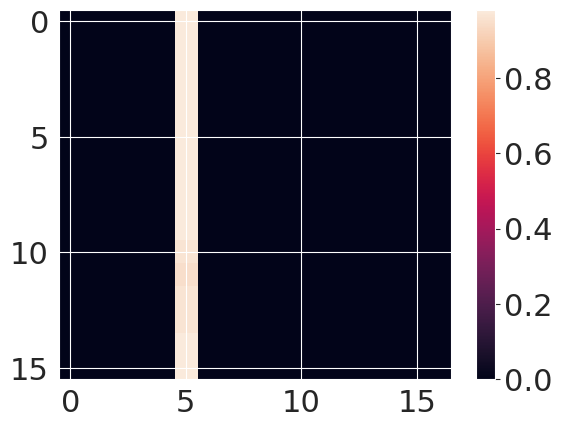

ORIGINAL LABEL: 1 COORDINATES [ 14.677562 -7.2920966 ]


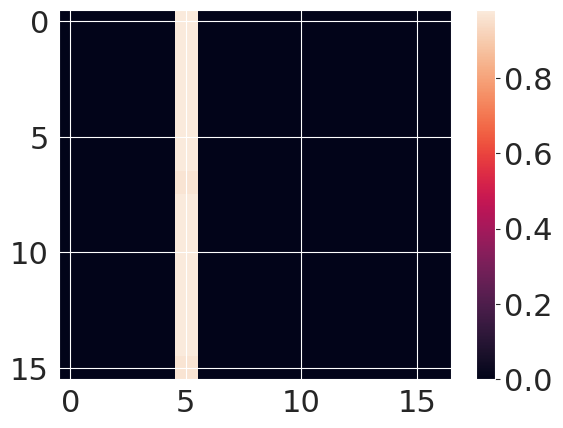

ORIGINAL LABEL: 0 COORDINATES [ 10.585853 -21.560963 ]


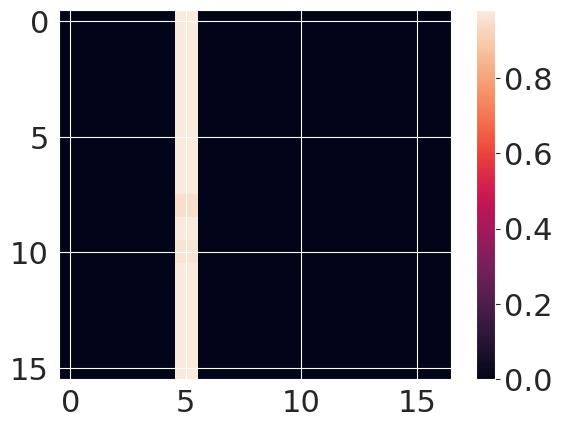

ORIGINAL LABEL: 2 COORDINATES [ 28.677284 -2.3782957 ]


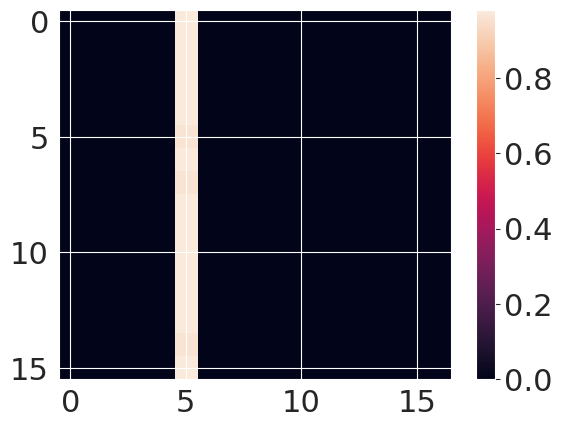

ORIGINAL LABEL: 0 COORDINATES [ 37.494286 -32.642494 ]


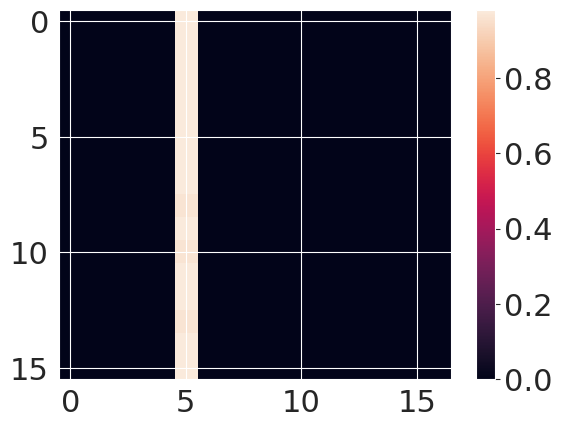

ORIGINAL LABEL: 1 COORDINATES [ 9.68251 -20.142881 ]


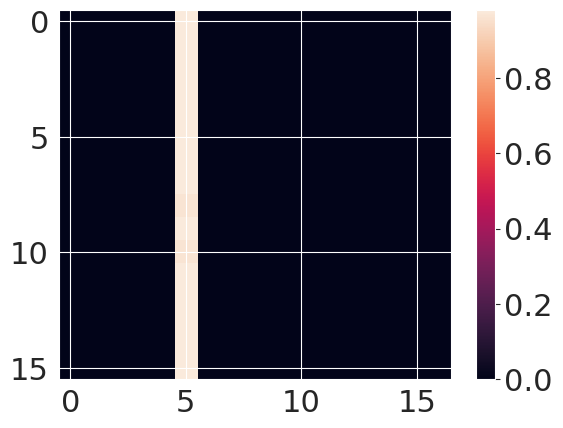

ORIGINAL LABEL: 1 COORDINATES [ 2.9600348 -26.437197 ]


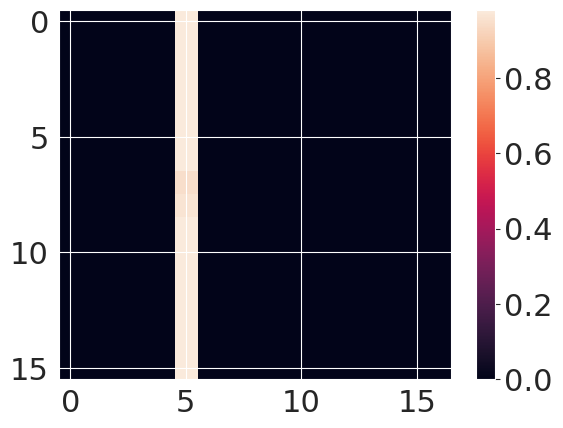

ORIGINAL LABEL: 0 COORDINATES [ 38.83991 -14.806691 ]


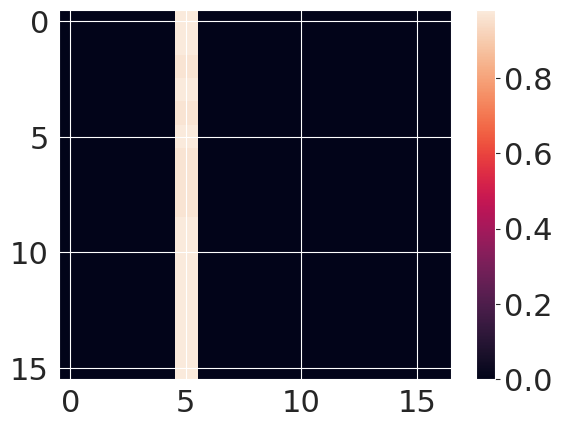

ORIGINAL LABEL: 2 COORDINATES [ 33.429874 -47.26519 ]


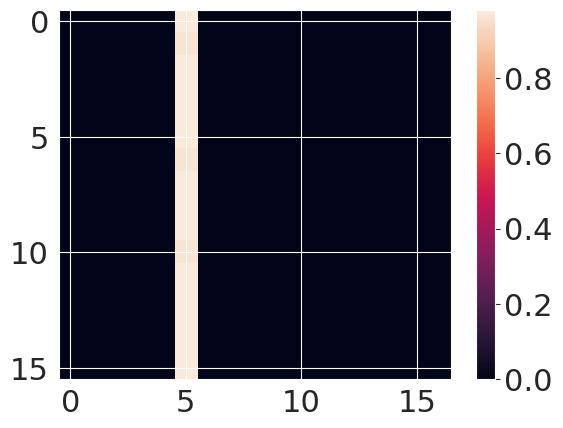

ORIGINAL LABEL: 0 COORDINATES [ 45.09325 -2.0312665 ]


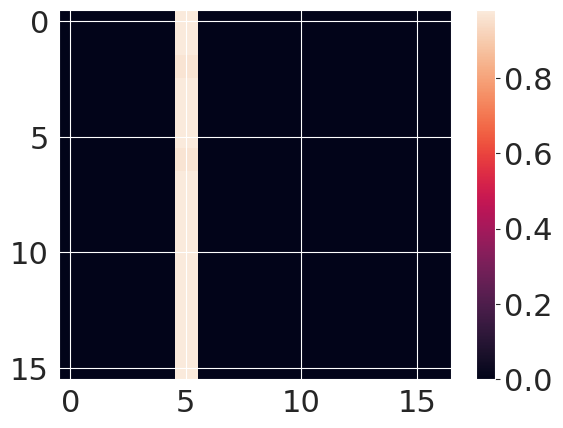

In [19]:
for c_ix in np.random.choice(ctrl_after_relabel_ixs, size=[30,]):
    if (50 > tsne_results[c_ix,0] > 0) and (0 > tsne_results[c_ix,1] > -50):
        print("ORIGINAL LABEL:", df_classes_nr[c_ix], "COORDINATES [", tsne_results[c_ix,0], tsne_results[c_ix,1], "]")
        matplotlib.pyplot.imshow(df_subset_og_shape[c_ix])
        matplotlib.pyplot.colorbar()
        matplotlib.pyplot.show()
        

Now instead we take a look at the original CTRL samples included in the dataset (i.e. *before* relabeling) that lie closer to the rest of the dataset samples, i.e. with coordinates $x < 30$ and $y < 0$. From such plots we note how CTRL samples do not in fact always present the same pattern, but rather show other activity going on in other KPIs that are usually pretty flat while traffic is idle. This highlights, despite the large number of samples relabeled, how conservative our relabeling mechanism is and that we should investigate better ways to capture also these more subtle CTRL traffic instances (note that CTRL traffic is collected by simply associating the UE to gNB but without running any particular traffic). 

In [20]:
ctrl_before_relabel_ixs = np.where(np.array(df_classes_nr) == 3)[0]

ORIGINAL LABEL: 3 COORDINATES [ -11.383375 79.30911 ]


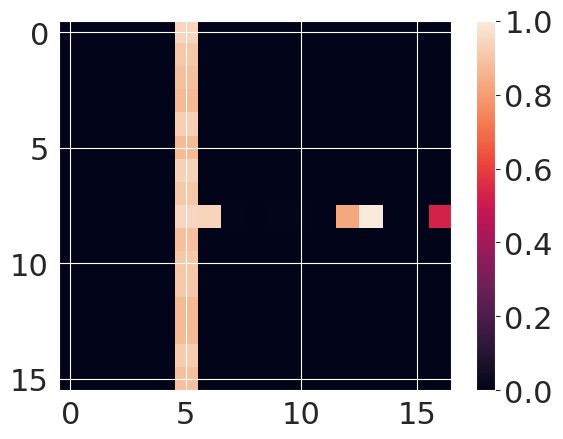

ORIGINAL LABEL: 3 COORDINATES [ -25.857 84.065315 ]


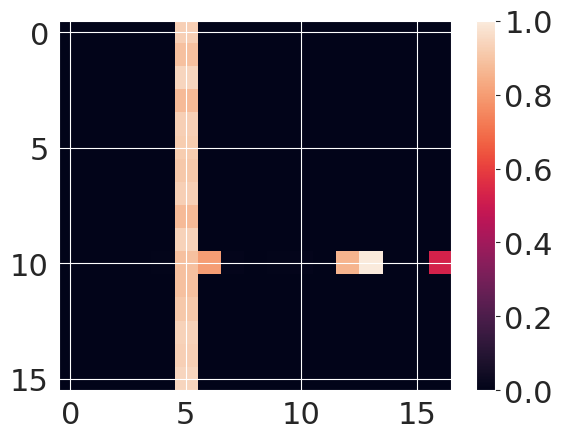

ORIGINAL LABEL: 3 COORDINATES [ -25.406004 102.60382 ]


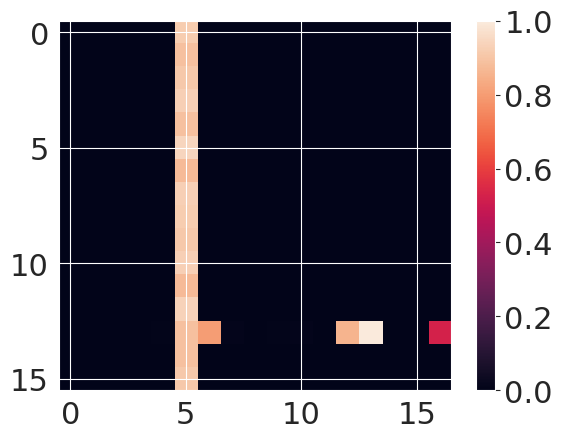

ORIGINAL LABEL: 3 COORDINATES [ 15.370077 42.356438 ]


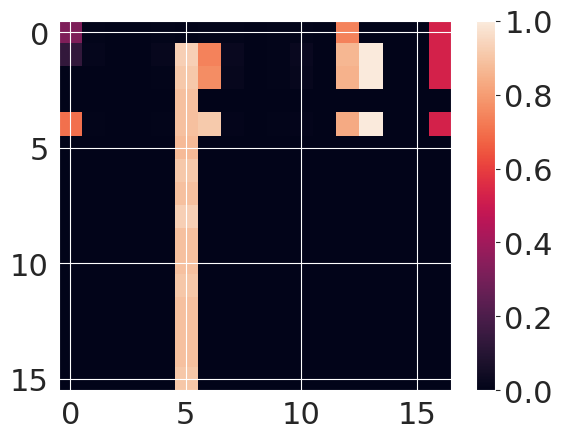

ORIGINAL LABEL: 3 COORDINATES [ -2.0808952 75.071396 ]


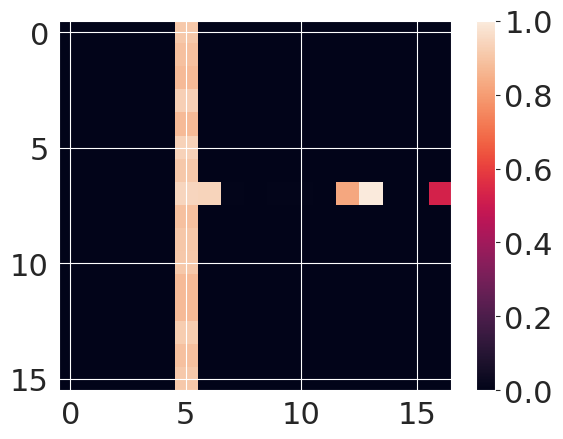

ORIGINAL LABEL: 3 COORDINATES [ -2.6463356 112.47042 ]


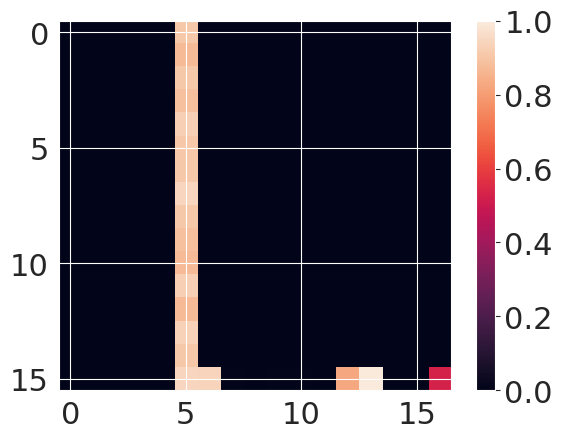

ORIGINAL LABEL: 3 COORDINATES [ 11.533692 98.845665 ]


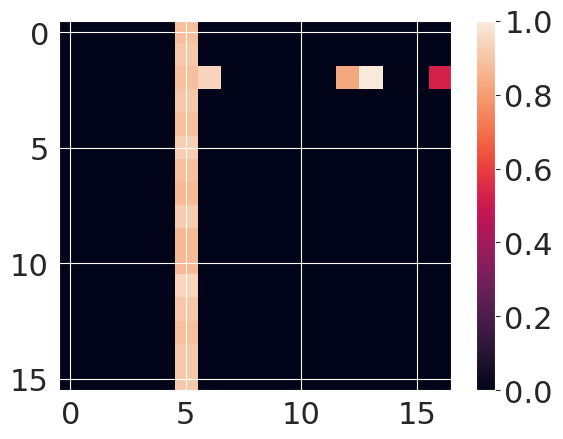

ORIGINAL LABEL: 3 COORDINATES [ -17.102718 56.329685 ]


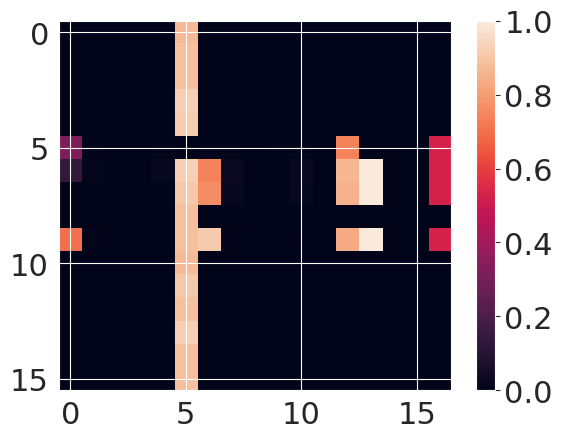

ORIGINAL LABEL: 3 COORDINATES [ -5.451345 60.12551 ]


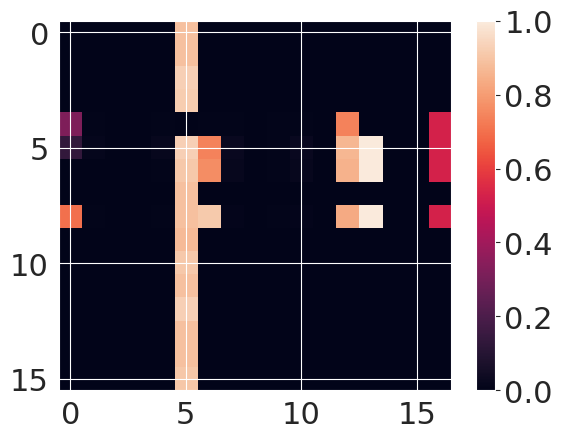

ORIGINAL LABEL: 3 COORDINATES [ 14.109773 71.02658 ]


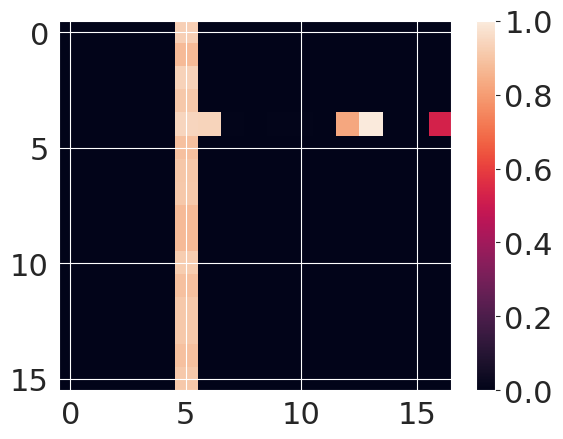

ORIGINAL LABEL: 3 COORDINATES [ 11.45458 98.73958 ]


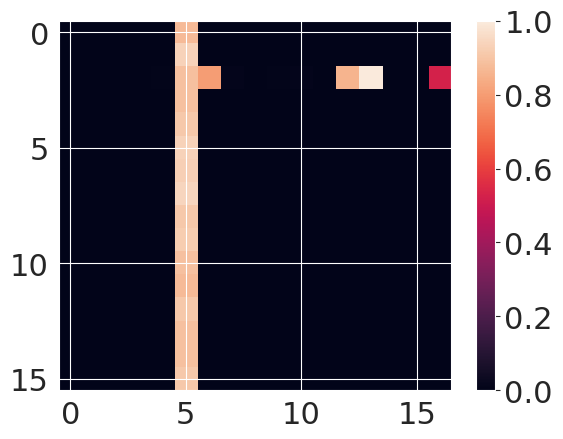

ORIGINAL LABEL: 3 COORDINATES [ -58.399006 91.55087 ]


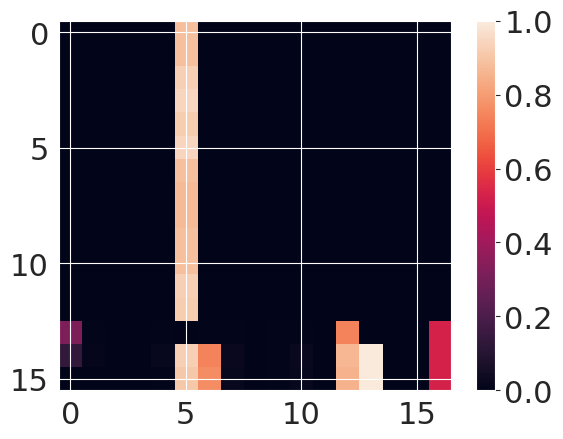

ORIGINAL LABEL: 3 COORDINATES [ 18.596447 80.64365 ]


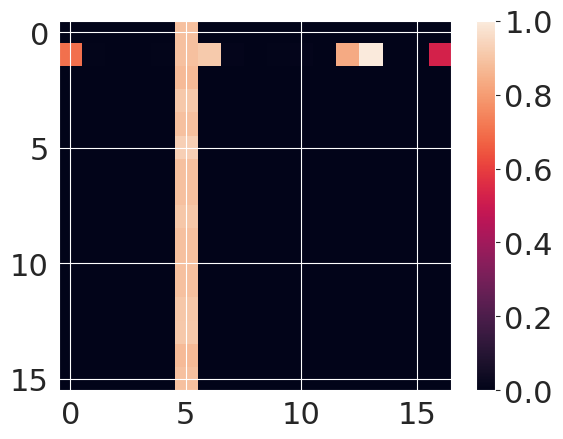

ORIGINAL LABEL: 3 COORDINATES [ 26.479937 84.555115 ]


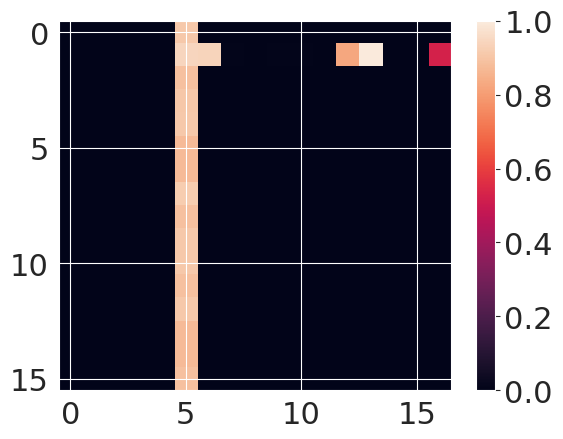

ORIGINAL LABEL: 3 COORDINATES [ -34.916862 93.410095 ]


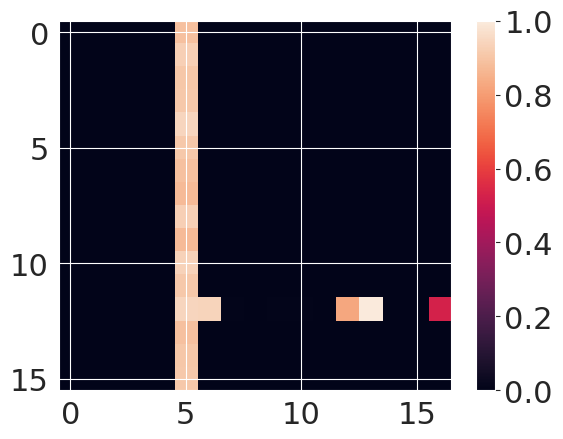

ORIGINAL LABEL: 3 COORDINATES [ -33.696045 72.327034 ]


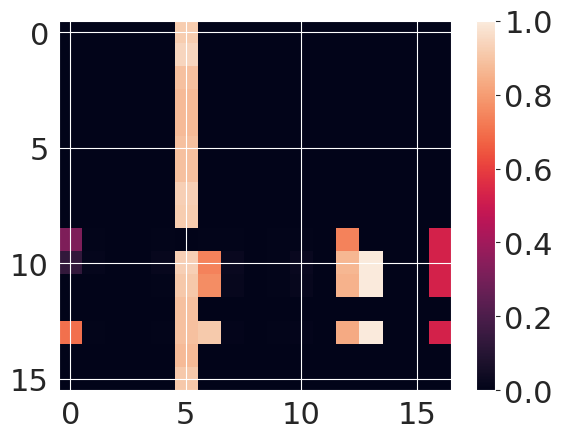

ORIGINAL LABEL: 3 COORDINATES [ 14.126749 71.0216 ]


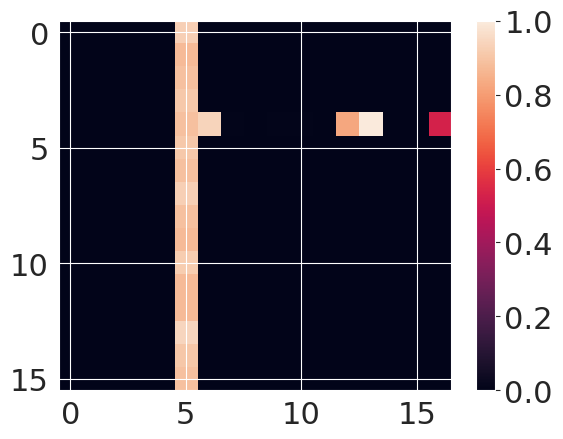

ORIGINAL LABEL: 3 COORDINATES [ -11.732369 79.403915 ]


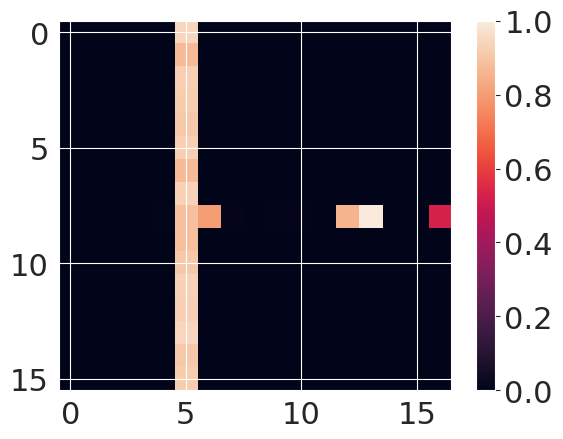

ORIGINAL LABEL: 3 COORDINATES [ 14.178833 70.88472 ]


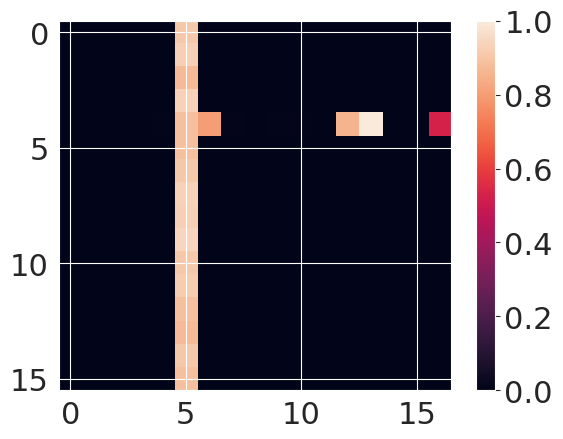

ORIGINAL LABEL: 3 COORDINATES [ 17.661919 34.565495 ]


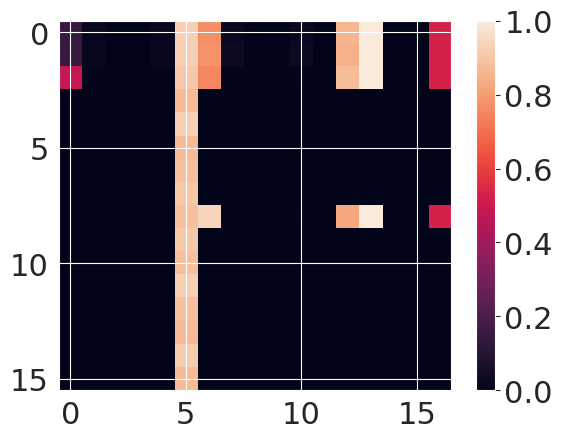

ORIGINAL LABEL: 3 COORDINATES [ -25.109884 102.60769 ]


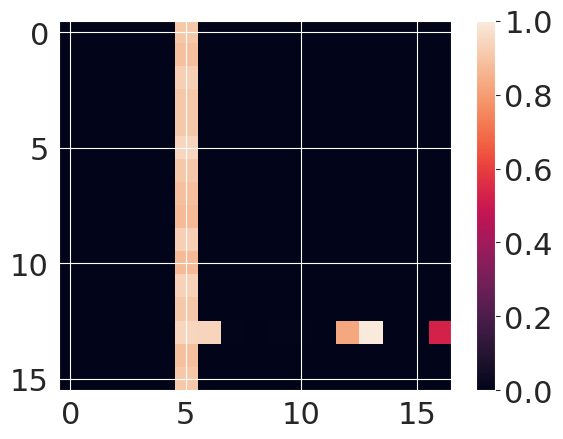

ORIGINAL LABEL: 3 COORDINATES [ -44.23971 61.421974 ]


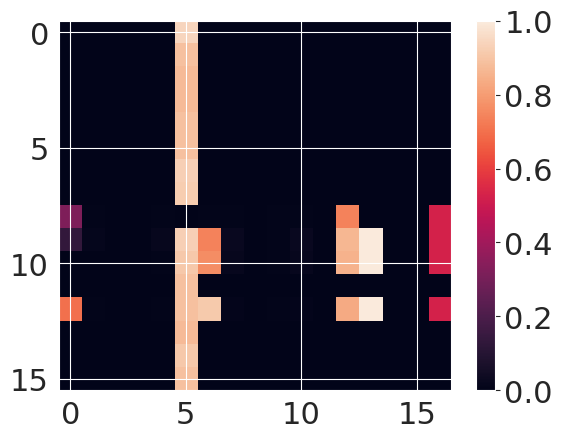

ORIGINAL LABEL: 3 COORDINATES [ 26.475027 84.56024 ]


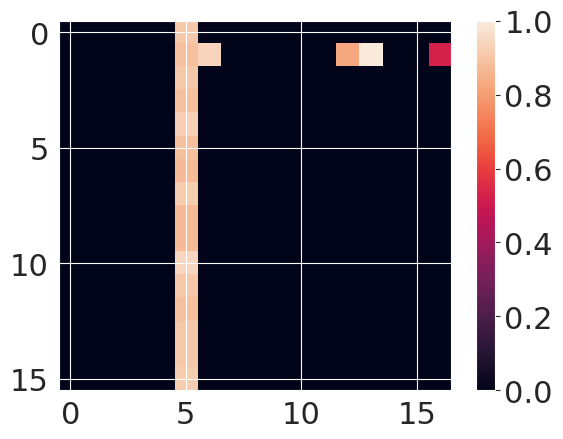

ORIGINAL LABEL: 3 COORDINATES [ -15.357154 93.86845 ]


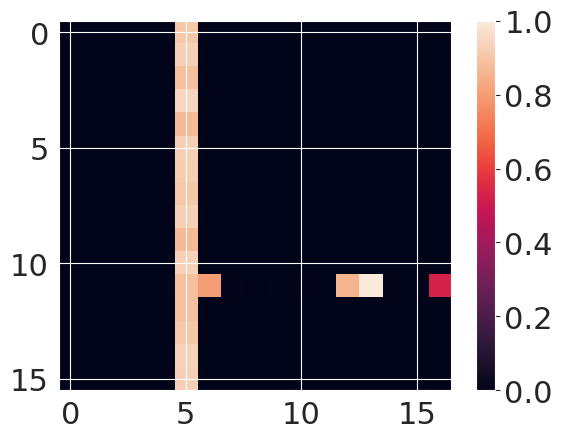

ORIGINAL LABEL: 3 COORDINATES [ 21.695017 97.81041 ]


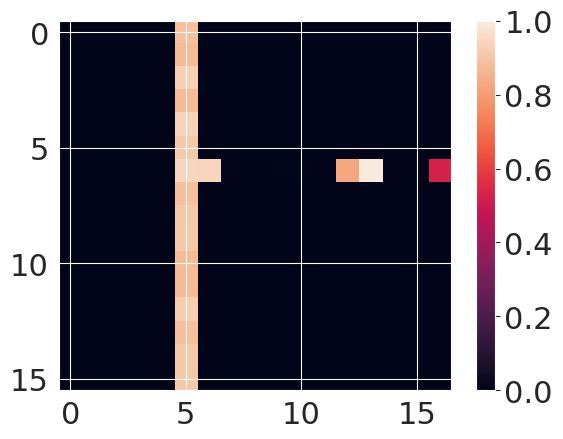

ORIGINAL LABEL: 3 COORDINATES [ 11.534671 98.852455 ]


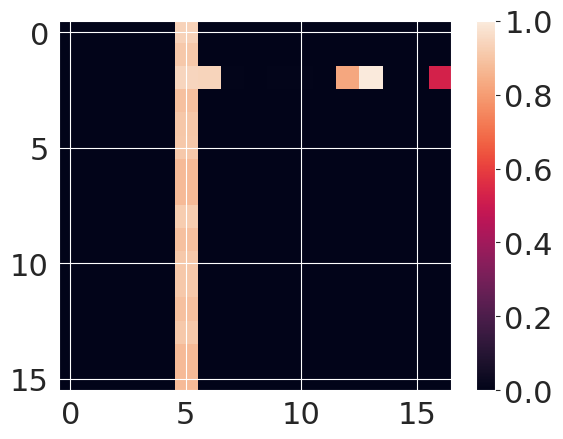

ORIGINAL LABEL: 3 COORDINATES [ -44.656048 75.04351 ]


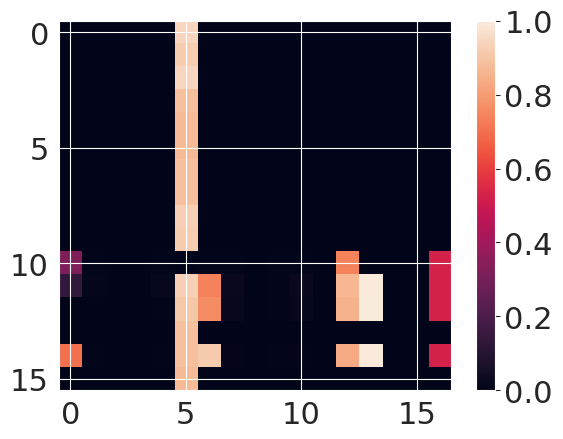

ORIGINAL LABEL: 3 COORDINATES [ 10.391708 58.11803 ]


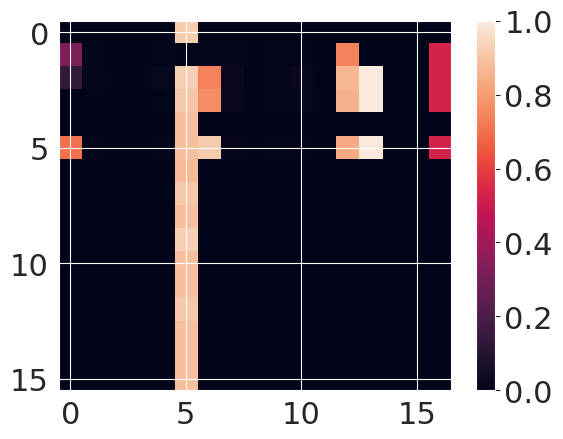

ORIGINAL LABEL: 3 COORDINATES [ 8.835478 84.88611 ]


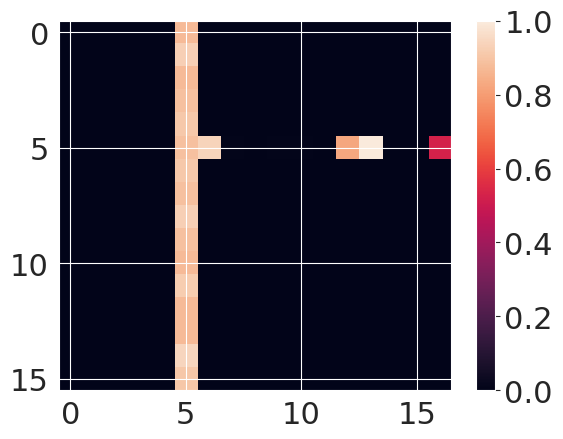

ORIGINAL LABEL: 3 COORDINATES [ -15.669016 93.7949 ]


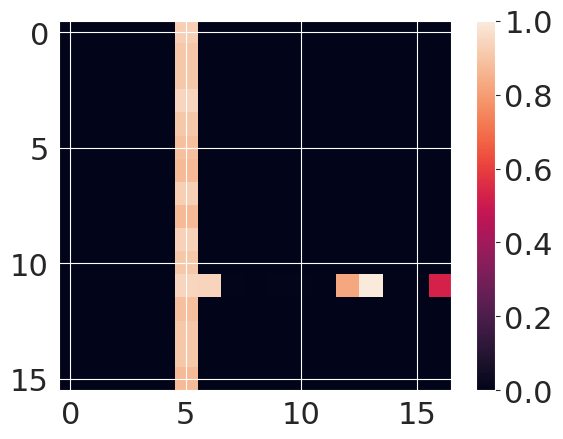

ORIGINAL LABEL: 3 COORDINATES [ -25.54279 83.96188 ]


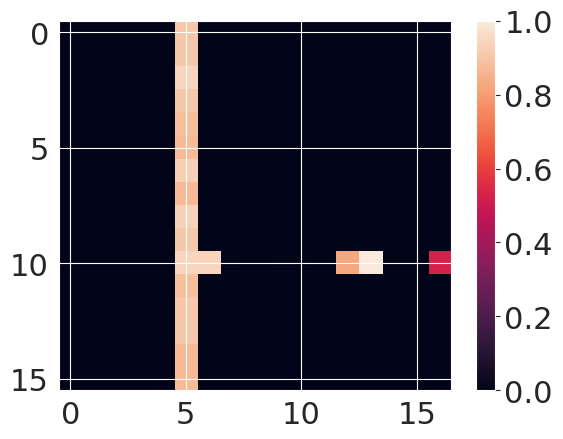

ORIGINAL LABEL: 3 COORDINATES [ -54.29272 75.25967 ]


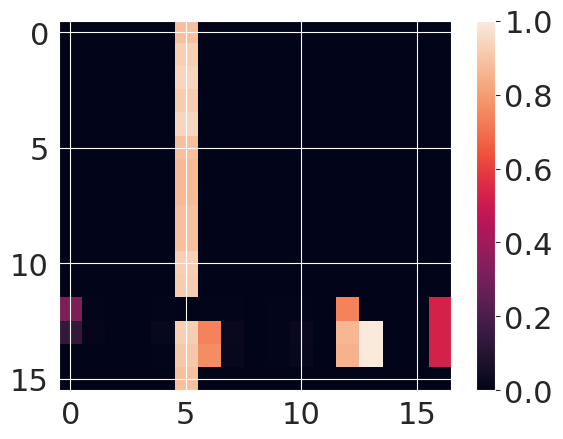

ORIGINAL LABEL: 3 COORDINATES [ 6.365797 38.52584 ]


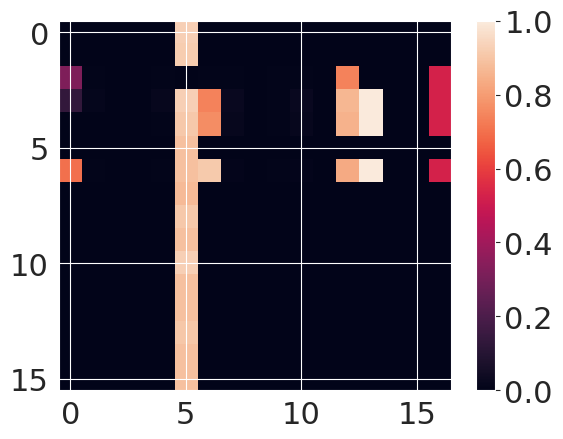

ORIGINAL LABEL: 3 COORDINATES [ 26.114906 51.598553 ]


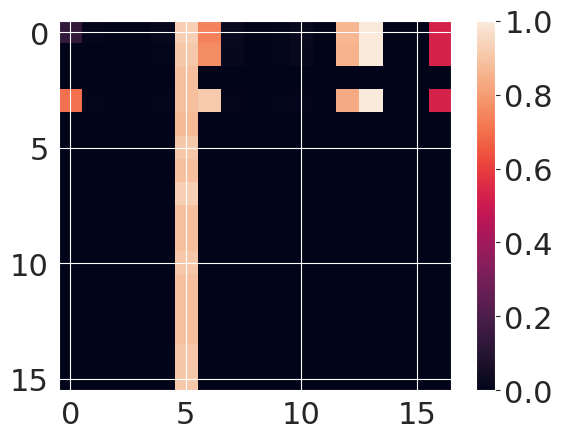

ORIGINAL LABEL: 3 COORDINATES [ -5.4876003 46.56485 ]


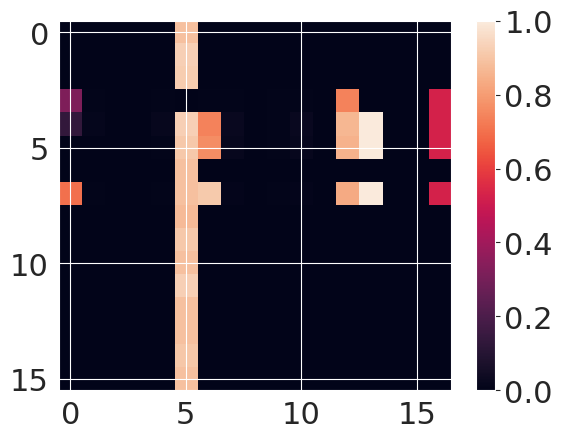

ORIGINAL LABEL: 3 COORDINATES [ 21.395771 97.83506 ]


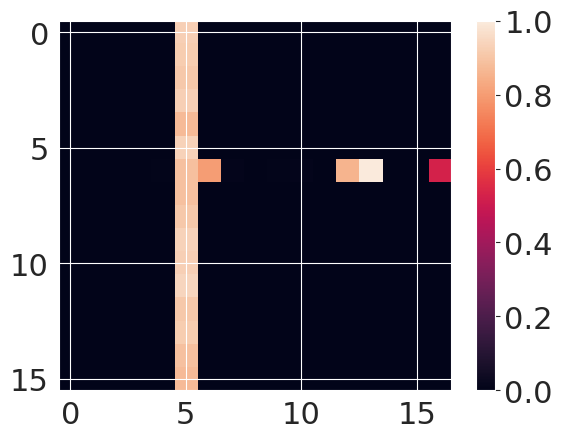

ORIGINAL LABEL: 3 COORDINATES [ -63.23141 57.713547 ]


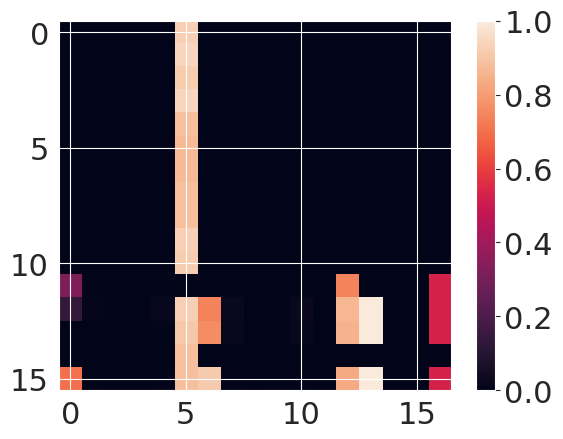

ORIGINAL LABEL: 3 COORDINATES [ -1.9112127 74.93052 ]


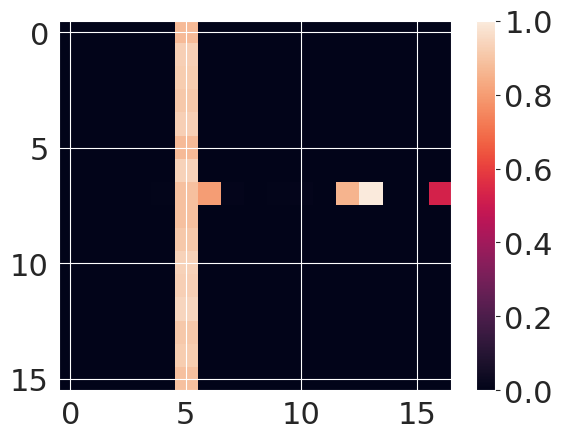

In [21]:
for c_ix in ctrl_before_relabel_ixs:
    if (tsne_results[c_ix,0] < 30) and ( tsne_results[c_ix,1] > 0):
        print("ORIGINAL LABEL:", df_classes_nr[c_ix], "COORDINATES [", tsne_results[c_ix,0], tsne_results[c_ix,1], "]")
        matplotlib.pyplot.imshow(df_subset_og_shape[c_ix])
        matplotlib.pyplot.colorbar()
        matplotlib.pyplot.show()